# Problem set 2 - Thomas Vandal

In [3]:
# all imports for the problem set
import warnings

import numpy as np
import matplotlib.pyplot as plt

## Problem 1
First, let's define some functions that we will need for this problem. Each method is described in its definition.

In [4]:
def xmap(x, a, b):
    """Re-map x range to [-1, 1] intv to allow chebyshev fit

    Use transformation y=(x - 0.5 * (b+a)) / (0.5 * (b-a)) to map an arbitrary
    range to [-1, 1]. (from numerical recipes)

    Args:
        x:   array of x values

    Returns:
        x mapped to [-1, 1]
    """
    bpa = 0.5 * (b + a)
    bma = 0.5 * (b - a)

    return (x - bpa) / bma


def chebmat(x, ord):
    """Compute Chebyshev polynomials at x-values for orders between 0 and ord
    Args:
        x:   sorted x values where each poly is evaluated
        ord: order of the highest polynomial to evaluate
    Returns:
        p: array of shape (len(x), ord) containing the polynomial evaluations.
           Each row contains all orders for one x value.
    """
    # sanity check
    ord = int(ord)  # convert order to integer if not already
    assert ord >= 0, "ord cannot be negative."

    # re-map x to the interval -1,1
    a, b = x[0], x[len(x)-1]
    x = xmap(x, a, b)

    # evaluate chebyshev
    p = np.zeros([len(x), ord+1])
    p[:, 0] = 1.0
    if ord > 0:
        p[:, 1] = x
    if ord > 1:
        for i in range(1, ord):
            p[:, i+1] = 2*x*p[:, i] - p[:, i-1]

    return p


def chebfit(x, y, ord):
    """Compute Chebyshev coefficients best fitting noise-free dataset

    The coefficents are computed using least-squares method.

    Args:
        x:   x data
        y:   y data
        ord: max order coefficent to compute
    Returns:
        c: coefficents corresponding to Chebyshev best-fit
    """
    # sanity check
    ord = int(ord)  # convert order to integer if not already
    assert ord >= 0, "ord cannot be negative."
    assert ord+1 < len(x), (  # even when true, might need reduce
                            "number of parameters equal to number of points..."
                            " try using a smaller order"
                           )

    # least-squares computation (with no noise, i.e. identity)
    amat = chebmat(x, ord)  # design matrix (basis evaluated at x)
    lhs = np.dot(amat.T, amat)
    rhs = np.dot(amat.T, y)
    c = np.dot(np.linalg.inv(lhs), rhs)

    return c


def chebeval(xnew, c, tol=1e-6):
    """Evaluate Chebyshev series

    Evaluates chebyshev series up to order len(c)-1.
    The series is truncated at before first coeffcicent with abs value less
    than the tolerance.

    Args:
        xnew: x values where the series is computed
        c:    coefficents used to evaluate series
        tol:  tolerance on the error
    Returns (tuple):
        ypred:  Chebyshev fit at xnew
        nterms: final number of terms needed for the fit (order+1)
    """
    # truncate coeff array
    try:
        indtrunc = np.argwhere(np.abs(c) < tol).flatten()[0]
        c = c[:indtrunc]
    except IndexError:
        coeff_warn = ("The coefficients did not satisfy tolerance... "
                      "chebeval will use all available coefficients")
        warnings.warn(coeff_warn, RuntimeWarning)
    nterms = len(c)  # final number of terms needed

    # evaluate cheb fit
    pmat = chebmat(xnew, len(c)-1)  # new polynomial values
    ypred = np.dot(pmat, c)

    return ypred, nterms


def chebpred(x, y, maxord, tol=1e-6):
    """Use Chebyshev polynomials to generate predictive fit on data
    This routine simply wraps up the previous methods in one call.
    Args:
        x:       x data
        y:       y data
        maxord:  max order coefficent to compute
        tol:     tolerance on the error
    Returns (tuple):
        ypred:  Chebyshev fit at xnew
        nterms: final number of terms needed for the fit (order+1)
    """
    coeffs = chebfit(x, y, maxord)
    ypred, nterms = chebeval(x, coeffs, tol=tol)

    return ypred, nterms

### Part (a)


Initial number of terms: 51
Number of terms needed: 8
Chebyshev fit has RMSE = 1.9403147425900195e-07, Max Err. = 3.1833769753575325e-07.
Regular poly. fit has RMSE = 1.800042913798546e-07, Max Err. = 6.004916612845079e-07.


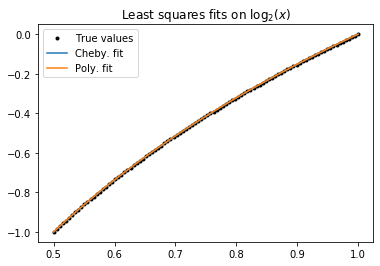

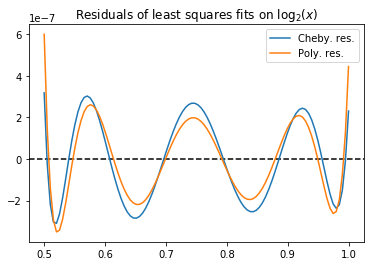

In [5]:
npts = 100
ord = 50
tol = 1e-6
# "data" to fit
x = np.linspace(0.5, 1.0, num=npts)    # x values evenly sampled
y = np.log2(x)                        # noiseless y "data"

# cheb best fit
ypred, nterms = chebpred(x, y, ord, tol=tol)
res = ypred - y
print("Initial number of terms: {}".format(ord+1))
print("Number of terms needed: {}".format(nterms))

# regular poly best fit
polypars = np.polyfit(x, y, deg=nterms-1)  # order is less than nterms
ypred2 = np.polyval(polypars, x)
res2 = ypred2 - y

# compare the two fits
print("Chebyshev fit has RMSE = {}, Max Err. = {}.".format(
                                                    np.sqrt(np.mean(res**2)),
                                                    np.max(np.abs(res))
                                                       )
      )
print("Regular poly. fit has RMSE = {}, Max Err. = {}.".format(
                                                    np.sqrt(np.mean(res2**2)),
                                                    np.max(np.abs(res2))
                                                       )
      )

plt.figure()
plt.plot(x, y, 'k.', label="True values")
plt.plot(x, ypred, label="Cheby. fit")
plt.plot(x, ypred2, label="Poly. fit")
plt.title(r"Least squares fits on $\log_{2}\left(x\right)$")
plt.legend()
plt.show()

plt.figure()
plt.axhline(linestyle='--', color='k')
plt.plot(x, res, label="Cheby. res.")
plt.plot(x, res2, label="Poly. res.")
plt.title(r"Residuals of least squares fits on $\log_{2}\left(x\right)$")
plt.legend()
plt.show()

We see above that the two Methods behave almost the same way in this range.

### Part (b)
The interval polyvalence is implemented above with xmap, which allows to map any x range to (-1,1). First, let's adjust the range only for the Chebyshev fit (not the other poly).

Initial number of terms: 101
Number of terms needed: 75
Chebyshev fit has RMSE = 8.036081336302672e-07, Max Err. = 6.014800036702184e-06.
Regular poly. fit has RMSE = 0.007352646717914129, Max Err. = 0.12440637944779187.


/home/thomas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


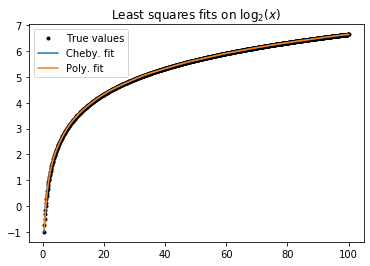

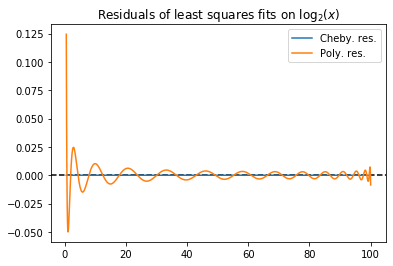

In [6]:
# example where we adjust the interval for cheby only
npts = 1000
ord = 100
tol = 1e-6
# "data" to fit
x = np.linspace(0.5, 100, num=npts)    # x values evenly sampled
y = np.log2(x)                        # noiseless y "data"

# cheb best fit
ypred, nterms = chebpred(x, y, ord, tol=tol)
res = ypred - y
print("Initial number of terms: {}".format(ord+1))
print("Number of terms needed: {}".format(nterms))

# regular poly best fit
polypars = np.polyfit(x, y, deg=nterms-1)  # order is less than nterms
ypred2 = np.polyval(polypars, x)
res2 = ypred2 - y

# compare the two fits
print("Chebyshev fit has RMSE = {}, Max Err. = {}.".format(
                                                    np.sqrt(np.mean(res**2)),
                                                    np.max(np.abs(res))
                                                       )
      )
print("Regular poly. fit has RMSE = {}, Max Err. = {}.".format(
                                                    np.sqrt(np.mean(res2**2)),
                                                    np.max(np.abs(res2))
                                                       )
      )

plt.figure()
plt.plot(x, y, 'k.', label="True values")
plt.plot(x, ypred, label="Cheby. fit")
plt.plot(x, ypred2, label="Poly. fit")
plt.title(r"Least squares fits on $\log_{2}\left(x\right)$")
plt.legend()
plt.show()

plt.figure()
plt.axhline(linestyle='--', color='k')
plt.plot(x, res, label="Cheby. res.")
plt.plot(x, res2, label="Poly. res.")
plt.title(r"Residuals of least squares fits on $\log_{2}\left(x\right)$")
plt.legend()
plt.show()

Now, let's adjust the range for both and see what we get.

Initial number of terms: 101
Number of terms needed: 75
Chebyshev fit has RMSE = 8.036081336302672e-07, Max Err. = 6.014800036702184e-06.
Regular poly. fit has RMSE = 2.125215285481227e-05, Max Err. = 0.0003377991943552816.


/home/thomas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


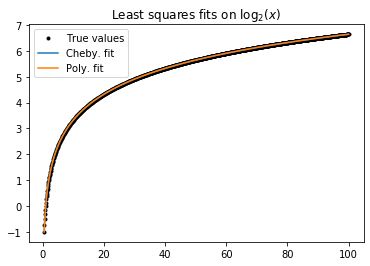

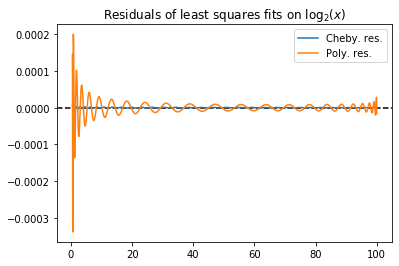

In [7]:
# example where we adjust the interval for both cheby AND polyfit
npts = 1000
ord = 100
tol = 1e-6
# "data" to fit
x = np.linspace(0.5, 100, num=npts)    # x values evenly sampled
y = np.log2(x)                        # noiseless y "data"

# cheb best fit
ypred, nterms = chebpred(x, y, ord, tol=tol)
res = ypred - y
print("Initial number of terms: {}".format(ord+1))
print("Number of terms needed: {}".format(nterms))

# regular poly best fit
xpoly = xmap(x, x[0], x[len(x)-1])
polypars = np.polyfit(xpoly, y, deg=nterms-1)  # order is less than nterms
ypred2 = np.polyval(polypars, xpoly)
res2 = ypred2 - y

# compare the two fits
print("Chebyshev fit has RMSE = {}, Max Err. = {}.".format(
                                                    np.sqrt(np.mean(res**2)),
                                                    np.max(np.abs(res))
                                                       )
      )
print("Regular poly. fit has RMSE = {}, Max Err. = {}.".format(
                                                    np.sqrt(np.mean(res2**2)),
                                                    np.max(np.abs(res2))
                                                       )
      )

plt.figure()
plt.plot(x, y, 'k.', label="True values")
plt.plot(x, ypred, label="Cheby. fit")
plt.plot(x, ypred2, label="Poly. fit")
plt.title(r"Least squares fits on $\log_{2}\left(x\right)$")
plt.legend()
plt.show()

plt.figure()
plt.axhline(linestyle='--', color='k')
plt.plot(x, res, label="Cheby. res.")
plt.plot(x, res2, label="Poly. res.")
plt.title(r"Residuals of least squares fits on $\log_{2}\left(x\right)$")
plt.legend()
plt.show()

As we see above, for an arbitrary range, Chebyshev is better.

## Problem 2
Let's load and visualize the dataset

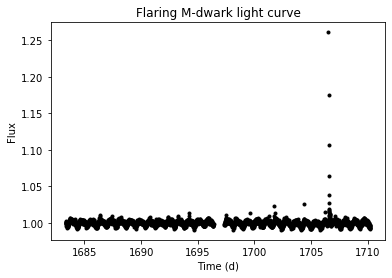

In [8]:
# load data
time, flux, _ = np.loadtxt(
    "/home/thomas/OneDrive/phys512/problem_sets/229614158_PDCSAP_SC6.txt",
    delimiter=','
                        ).T
# visualize light curve
plt.figure()
plt.plot(time, flux, 'k.')
plt.xlabel("Time (d)")
plt.ylabel("Flux")
plt.title("Flaring M-dwark light curve")
plt.show()

## Part (a)
We will now select an interval around the flare and use an exponential decay to model. We first need to guess the parameters. I combined the amplitude and the time offset in one parameter (x0) to avoid degeneracy.

Initial Guess on parameters:
  Offset and amplitude: t0 = 1706.4962776431853
  Decay rate (1/day):   b = 50
  Flux offset:          off = 1.0


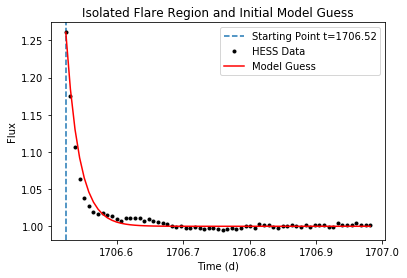

In [10]:
# define model
def expdec(x, p):
    """General Exponential Decay Model

    To avoid degeneracy between the amplitude and the x offset, we combine
    them into one x0 term

    Args:
        x: values where the model is evaluated
        p: array of parameters [x0, b, yoff]
            x0:   term combining the x offset and the amplitude
            b:    decay rate
            yoff: y offset on model

    Returns e^(b(x-x0)) + yoff
    """

    return np.exp(-p[1]*(x-p[0])) + p[2]


# find a region that will work well for modelling
istart = np.argmax(flux)  # where flux is max
iend = np.max(np.argwhere(time <= 1707))  # determined by eye
time = time[istart:iend]
flux = flux[istart:iend]

fluxoff = 1.0  # guessed by eye (when no changes happen flux=1.0)
amp = flux[0] - fluxoff  # flare amplitude
b = 50                   # trial and error guess for the decay rate
t0 = time[0] + np.log(amp) / b  # combine amplitude in exponential
pguess = [t0, b, fluxoff]
print("Initial Guess on parameters:")
print("  Offset and amplitude: t0 = {}".format(pguess[0]))
print("  Decay rate (1/day):   b = {}".format(pguess[1]))
print("  Flux offset:          off = {}".format(pguess[2]))
eguess = expdec(time, pguess)

plt.figure()
plt.axvline(x=time[0], linestyle='--',
            label="Starting Point t={:.2f}".format(time[0]))
plt.plot(time, flux, 'k.', label="HESS Data")
plt.plot(time, eguess, 'r', label="Model Guess")
plt.xlabel("Time (d)")
plt.ylabel("Flux")
plt.title("Isolated Flare Region and Initial Model Guess")
plt.legend()
plt.show()

### Parts (b) and (c)
We now use Newton method to find the best fit. An estimate of the parameters error is made using the sqrt of the diagonal of the covariance matrix.

The Newton Method converged after 4 iterations
The best fit parameters are:
  Offset and amplitude: t0 = 1706.502412775013 ± 0.00025767513101327604
  Decay rate (1/day):   b = 64.82465439098968 ± 0.632792321398746
  Flux offset:          off = 1.0018644396169374 ± 2.427669136374521e-05


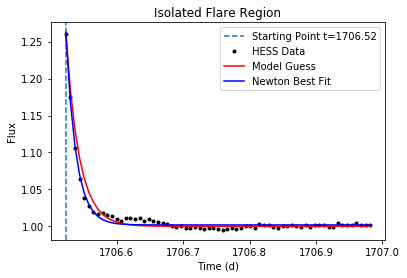

In [11]:
def expdec_grad(x, p):
    """Compute Gradient of expdec_wrap function
    Args:
        x: values where the model is evaluated
        p: array of parameters [x0, b, yoff]
            x0:   term combining the x offset and the amplitude
            b:    decay rate
            yoff: y offset on model
    Returns:
        g: gradient of expdec at each value x with shape (len(x), len(p))
    """
    g = np.zeros([len(x), len(p)])
    # g[:, 0] = np.exp(-p[2]*(x-p[1]))
    # g[:, 1] = p[0] * p[2] * np.exp(-p[2]*(x-p[1]))
    # g[:, 2] = -(x-p[1]) * p[0] * np.exp(-p[2]*(x-p[1]))
    # g[:, 3] = 1.0

    g[:, 0] = p[1] * np.exp(-p[1]*(x-p[0]))
    g[:, 1] = -(x-p[0]) * np.exp(-p[1]*(x-p[0]))
    g[:, 2] = 1.0

    return g


def newton(fun, gradfun, x, y, pguess, maxit=10, cstol=1e-3, dptol=1e-3):
    """Use newton methods to fit a function
    Args:
        fun:     function to fit with positional arguments (x, parameters)
        gradfun: gradient of fun with positional argumetns (x, parameters)
        x:       x data to fit
        y:       y data to fit
        pguess:  initial guess on parameters
        maxit:   maximum number of iterations
        cstol:   maximum chi-sq relative change for convergence
        dpar:    maximum parameter variation for convergence

    Returns:
        pars: optimized parameters
        cov:  estimate of the parameters covariance
    """
    pguess = np.array(pguess)  # make sure numpy array
    pars = pguess.copy()

    chisq_prev = 1e4  # high dummy chi-sq
    for j in range(maxit):

        pred = fun(x, pars)
        grad = gradfun(x, pars)

        res = y - pred
        chisq = np.sum(res**2)  # no ebars => no weights

        # generate matrix objects
        res = np.matrix(res).T
        grad = np.matrix(grad)

        # solve linear system
        lhs = grad.T * grad
        rhs = grad.T * res
        dpars = np.linalg.inv(lhs) * (rhs)
        dpars = np.asarray(dpars).flatten()
        for k in range(pguess.size):
            pars[k] = pars[k] + dpars[k]

        # convergence check
        csdiff = (chisq_prev - chisq) / chisq
        dprel = np.max(np.abs(dpars/pars))
        if j > 0 and csdiff < cstol and dprel < dptol:
            print("The Newton Method converged after {} iterations".format(j))
            break
        if j == maxit-1:
            msg = ("maxiter was reached without convergence... "
                   "params may be poorly constained")
            warnings.warn(msg, RuntimeWarning)

        chisq_prev = chisq

    # estimate of parameters covariance
    finpred = fun(x, pars)
    fingrad = gradfun(x, pars)
    finres = y - finpred
    invnoise = np.diag(finres**(-2))   # assume noise on each pt is residuals
    tmp = np.dot(fingrad.T, invnoise)  # compute covariance matrix
    invcov = np.dot(tmp, fingrad)
    cov = np.linalg.inv(invcov)

    return pars, cov


p, cov = newton(expdec, expdec_grad, time, flux, pguess)
perr = np.sqrt(np.diag(cov))
print("The best fit parameters are:")
print("  Offset and amplitude: t0 = {} ± {}".format(p[0], perr[0]))
print("  Decay rate (1/day):   b = {} ± {}".format(p[1], perr[1]))
print("  Flux offset:          off = {} ± {}".format(p[2], perr[2]))

fit = expdec(time, p)

plt.figure()
plt.axvline(x=time[0], linestyle='--',
            label="Starting Point t={:.2f}".format(time[0]))
plt.plot(time, flux, 'k.', label="HESS Data")
plt.plot(time, eguess, 'r', label="Model Guess")
plt.plot(time, fit, 'b', label="Newton Best Fit")
plt.xlabel("Time (d)")
plt.ylabel("Flux")
plt.title("Isolated Flare Region")
plt.legend()
plt.show()

These error seem reasonable (not too large, maybe a bit small). If we had used amplitude and t0 separately, the covariance might have been very large, but this was avoided.

### Part (d)
By looking at the data (first plot in the problem), there is clearly correlated noise and we should model this with something (multi-sine fit, Gaussian Process, etc.). Also we did not put any error bars on the data... Therefore, I do not trust the error that much. Before claiming these are the actual errors, I would at least do some Monte-Carlo analysis (e.g. bootstrap) with the residuals, and ideally I would model the correlated noise. 